### Prelims

In [ ]:
import numpy as np
from numpy import random
import pandas as pd
import sympy as sp
from sympy import symbols,diff, simplify, integrate
from sympy.stats import cdf, Normal

import math
from math import pow, exp, sqrt
from scipy import stats
norm = stats.norm

import timeit
from tqdm import tqdm

import numba
from numba.np.ufunc import parallel
from scipy.special import erf
! pip install latex

#!pip install torch
#import latex
#import torch

In [ ]:
! pip show matplotlib
! pip install -U matplotlib
import matplotlib.pyplot as plt

Mark

We are basically trying to find the price or expected value of the payoff

$\int_0^T \sigma(t)^2 dt$.

We know under the risk neutral measure

$log(S_T)  = log(S_0) + \int_0^T r(t) dt - 1/2 \int_0^T \sigma(t)^2 dt + \int_0^T \sigma(t) dB_t$.  

The price is the expected discounted value.  Assuming the risk free rate is constant, the value of the contract which pays off $log(S_T)$ is

$E[e^{-r T} log(S_T)]$

which is equal to

$log(S_0) + e^{-rT} rT -e^{-rT} \frac{1}{2} E[\int_0^T \sigma(t)^2 dt]$  

which can be rearranged to find the price  (using discounting) or expected value of the integral.  The key is a portfolio of options can be used to find

$E[e^{-rT} log(S_T)]$.  

We find a portfolio of options which has payoffs $log(S_T)$ and its price is the discounted expectation we are looking for(of course everything is in the risk neutral measure).  The portfolio is given by the integral which is in my class notes.  Try evaluating the integral to see what you get and then look at the other pieces of the VIX.


ME

$log(S_T)  = log(S_0) + \int_0^T r(t) dt - 1/2 \int_0^T \sigma(t)^2 dt + \int_0^T \sigma(t) dB_t$

$log(S_T)-log(S_0)=log(\frac{S_T}{S_0})=\int_0^T r(t) dt - 1/2 \int_0^T \sigma(t)^2 dt$

$log(\frac{S_T}{S_0}) \approx rT - \frac{1}{2}\sigma(t)^2 T$

$\sigma(t)^2 = \frac{2}{T}[rT - log(\frac{S_T}{S_0})] ≈ \frac{2}{T}[\int_0^T r(t) dt - \int_0^T log(S_t) dt]$

Mark

Actually I meant the payoff to the portfolio in the integral

$\int_0^F (K-S_T)^+ \frac{1}{K^2} dK + \int_F^\infty (S_T - K)^+ \frac{1}{K^2} dK$  

notice where the options are in the money you get integrals of $\frac{1}{K}$ and $\frac{1}{K^2}$.  The integral of 1/K gives log you need to evaluate at the end points remember for K=0 the option is out of the money $(K-S_T)^+ =0$ so you aren't integrating over K=0 which would be a problem. (Actually, the lower boundary will be something like S_T) and the definition of F is in the notes.

In [ ]:
St, F, T = symbols('S_t F T', real=True)
fwd_contracts = (St-F)/F
log_contract = sp.log(St/F)
final = fwd_contracts-log_contract
final*=2/T
display(final)
print('--------------------------')

dV_dF = diff(final,F)
display(dV_dF)

print('--------------------------')
V_F = integrate(final,F)
display(V_F)

U,L = symbols('S_U S_L',real=True)
final2=integrate(final,(F,U,L))
#float(final2.subs({U:50,L:100}))


print('--------------------------')
U=100
L=50
S_ref=60
T_mat=1
print(float(final.subs({St:U,F:S_ref,T:T_mat})-final.subs({St:L,F:S_ref,T:T_mat})))
#print(-2*np.log(5/3))

2*(-log(S_t/F) + (-F + S_t)/F)/T

--------------------------


-2*(-F + S_t)/(F**2*T)

--------------------------


-2*F*log(S_t/F)/T + (-4*F + 2*S_t*log(F))/T

--------------------------
0.28037230554677606


In [ ]:
integrate(final,St)

# S**2/(T*T)-(2*S*np.log(S/F))/T

-2*S_t*log(S_t/F)/T + S_t**2/(F*T)

$\frac{2}{T}[-S_* log(\frac{S_T}{S_*}) + log(S_*)-2 S_*]$

$\frac{2}{T}[ log(S_*)-2 S_* -S_* log(\frac{S_T}{S_*}) ]$

In [ ]:
from sympy import oo,mellin_transform
S,K,F= symbols('S K F', real=True)
print('puts')
puts=sp.Max(K-S,0)
puts/=(K**2)
display(integrate(puts,(K,S,F)))


print('----------')
print('calls')
calls=sp.Max(S-K,0)
calls/=(K**2)
display(integrate(calls,(K,F,S)))
#display(integrate(calls,K))
#RHS = integrate(calls, K)


puts


Piecewise((log(F) - log(S) - 1 + S/F, F > S), (0, True))

----------
calls


Piecewise((log(F) - log(S) - 1 + S/F, F < S), (0, True))

In [ ]:
from sympy import oo,mellin_transform
S,K,F= symbols('S K F', real=True)
#print('puts')
puts=sp.Max(K-S,0)
puts/=(K**2)
#display(integrate(puts,(K,S,F)))


print('----------')
print('calls')
calls=sp.Max(S-K,0)
calls/=(K**2)
display(integrate(calls,(K,F,oo)))

----------
calls


-S/Max(F, S) + log(F) - log(Max(F, S)) + S/F

#### The VIX originates from trying to price the log contract, which pays off log($\frac{S(T)}{S(0)}$) at time T. The log contract gives us insight about expected future volatility.

#### The value of the log contract is: $E^*[e^{-rT} log(\frac{S(T)}{S(0)})] = e^{-rT}E^*[rT - \frac{1}{2} \int_{0}^{T} \sigma(t)^2 \,dt]$

#### The objective of the VIX is to replicate the payoff of the log contract using a portfolio of out-of-the money options on the S&P 500 Index.

In [ ]:
St, K, v, T, t = symbols('S_t S_* \sigma^2, T, t', real=True)
fwd_contracts = (St-K)/K
log_contract = sp.log(St/K)
var_remain = (T-t)*v
final = fwd_contracts-log_contract+var_remain
display(final)

print('stock price exposure')
print('--------------------')
dV_dS = diff(final,St)
display(dV_dS)
display(diff(log_contract,St))

final2 = (2/T)*(fwd_contracts-log_contract+var_remain/2)
display( diff(final2,St) )

print('--------------------')

print('variance exposure')
print('--------------------')
pi_t = fwd_contracts-log_contract+var_remain/2
display(diff(pi_t,v))
print( f'initial var exposure: {float( diff(pi_t,v).subs({T:1, t:0})  )}' )
pi_t_2 = pi_t * (2/T)
display(diff(pi_t_2,v))
print( f'new var exposure: {float( diff(pi_t_2,v).subs({T:1, t:0})  )}' )
print('--------------------')

# show that if S* = st then final has no exposure to the stock price

\sigma^2*(T - t) - log(S_t/S_*) + (-S_* + S_t)/S_*

stock price exposure
--------------------


-1/S_t + 1/S_*

1/S_t

2*(-1/S_t + 1/S_*)/T

--------------------
variance exposure
--------------------


T/2 - t/2

initial var exposure: 0.5


2*(T/2 - t/2)/T

new var exposure: 1.0
--------------------


In [ ]:
S0, K, r, sig, T = symbols('S0 K r sig T', real=True)
d1 = (sp.log(S0/K) + (r + sig**2/2) * T)/(sig*sp.sqrt(T))
d2 = d1 - sig*sp.sqrt(T)
x = Normal('x', 0, 1)
c = S0 * simplify(cdf(x))(d1) - K * sp.exp(-r * T) * simplify(cdf(x))(d2)
dk_dc=diff(c,K)
d2K_dc2=diff(dk_dc,K)
#display(dk_dc)
display(d2K_dc2)
#bs_delta = diff(c, S0)
#print('delta')
#print( float( bs_delta.subs({S0:100, sig:0.3, K:100, T:1, r:0.03})  ) )

sqrt(2)*(-sqrt(T)*sig + (T*(r + sig**2/2) + log(S0/K))/(sqrt(T)*sig))*exp(-T*r)*exp(-(-sqrt(T)*sig + (T*(r + sig**2/2) + log(S0/K))/(sqrt(T)*sig))**2/2)/(2*sqrt(pi)*K*T*sig**2) + sqrt(2)*exp(-T*r)*exp(-(-sqrt(T)*sig + (T*(r + sig**2/2) + log(S0/K))/(sqrt(T)*sig))**2/2)/(2*sqrt(pi)*K*sqrt(T)*sig) + sqrt(2)*S0*exp(-(T*(r + sig**2/2) + log(S0/K))**2/(2*T*sig**2))/(2*sqrt(pi)*K**2*sqrt(T)*sig) - sqrt(2)*S0*(T*(r + sig**2/2) + log(S0/K))*exp(-(T*(r + sig**2/2) + log(S0/K))**2/(2*T*sig**2))/(2*sqrt(pi)*K**2*T**(3/2)*sig**3)

#### Distributions to Option Prices

$f(S_T)=max(S_T-K,0)$=$\frac{S_T-K + |S_T-K|}{2}$

$\frac{∂f}{∂K}$

sign(K - S_T)/2 - 1/2

DiracDelta(K - S_T)

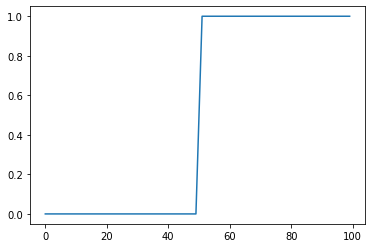

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


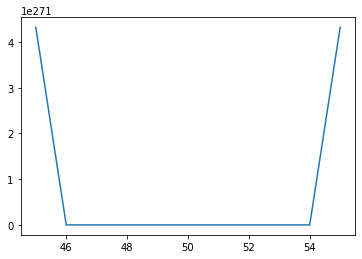

In [ ]:
S, K, T, t = symbols('S_T K, T, t', real=True)
#f = sp.maximum(S-K,0)
f= (S-K+sp.Abs(S-K))/2

#display(final)
df_dk = diff(f,K)
display(df_dk)

df2_d2k = diff(df_dk,K)
display(df2_d2k)

def first_deriv(S,K):
  return np.sign(K-S)/2 - 1/2

ST=np.arange(0,100)
K=50
plt.plot(ST,first_deriv(ST,K)*-1)
plt.show()
payoff_dict={}
#for s in ST:
#  payoff_dict[s]=float(df2_d2k.subs({S:s,K:50,T:1,t:1}))
#plt.plot(*zip(*payoff_dict.items()))
#plt.show()

#df2_d2k.subs({S:100,K:50})

def sec_deriv(S,K,a):
  lhs=1/(np.pi*abs(a))
  rhs=np.exp((-(S-K)/a)**2)
  return lhs*rhs

a=0.2
plt.plot(ST,sec_deriv(ST,K,a))
plt.show()

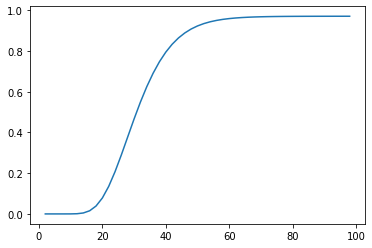

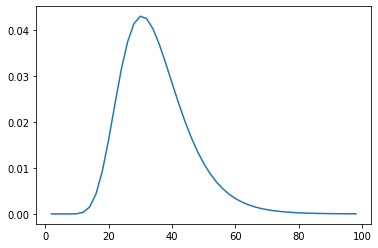

In [ ]:
S0, K, r, sig, T = symbols('S0 K r sig T', real=True)
d1 = (sp.log(S0/K) + (r + sig**2/2) * T)/(sig*sp.sqrt(T))
d2 = d1 - sig*sp.sqrt(T)
x = Normal('x', 0, 1)
c = S0 * simplify(cdf(x))(d1) - K * sp.exp(-r * T) * simplify(cdf(x))(d2)
dk_dc=diff(c,K)
d2K_dc2=diff(dk_dc,K)
#display(dk_dc)
#display(d2K_dc2)
#bs_delta = diff(c, S0)
#print('delta')
#print( float( bs_delta.subs({S0:100, sig:0.3, K:100, T:1, r:0.03})  ) )

payoff_dict={}
for s in range(0,100,2):
  payoff_dict[s]=-1*float(dk_dc.subs({S0:s, sig:0.3, K:30, T:1, r:0.03}))
plt.plot(*zip(*payoff_dict.items()))
plt.show()

payoff_dict={}
for s in range(0,100,2):
  payoff_dict[s]=float( d2K_dc2.subs({S0:s, sig:0.3, K:30, T:1, r:0.03})  )
plt.plot(*zip(*payoff_dict.items()))
plt.show()

#S,S_ref,T= symbols('S S* T', real=True)
#payoff=-sp.log(S/S_ref)*(2/T)
#delta = diff(payoff, S)
#delta

In [ ]:
class BSOPM_Class:

  def disc_function(self, FV, r, T):
    PV = FV * np.exp(-r*T)
    return PV

  def bs_d1_d2(self,St,r,t,K,call,sig):
    d1 = np.log(St/K)
    d1 += ( sig*sig/2 + r)*t
    with np.errstate(divide='ignore'):
        d1/=sig * t**0.5
    d2=d1-sig * t**0.5
    return d1,d2

  def cdf_approx(self,dn,call):
    if call:
      Ndn = (0.50 * (1.0 + erf(dn / math.sqrt(2.0))))
    else:
      Ndn = (0.50 * (1.0 + erf(-dn / math.sqrt(2.0))))
    return Ndn

  def bs_delta(self,d1,d2,call):
    Nd1 = self.cdf_approx(dn=d1,call=call)
    Nd2 = self.cdf_approx(dn=d2,call=call)
    return Nd1,Nd2

  def bs_gamma(self,d1,St,sig,t):
    gamma = norm.pdf(d1)
    with np.errstate(divide='ignore'):
        gamma /= (St*sig*np.sqrt(t))
    return gamma

  def bs_price(self,St,r,t,K,call,Nd1,Nd2,T):
    pvk = self.disc_function(K,r, T-t)
    if call:
      price = St*Nd1-pvk*Nd2
    else:
      price = pvk * Nd2 - St * Nd1
    return price

  def opt_payoff(self, ST, K, call=True):
    if call == True:
      payoff=np.maximum(ST-K,0)
    else:
      payoff=np.maximum(K-ST,0)
    return payoff

  def __init__(self,S0,r,sigma,t,T,K,call=True):
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T  = T
    self.K = K
    self.call = call
    self.t = t

    self.d1,self.d2=self.bs_d1_d2(St=self.S0,r=self.r,t=self.T-self.t,K=self.K,call=self.call,sig=self.sigma)
    self.Nd1,self.Nd2=self.bs_delta(d1=self.d1,d2=self.d2,call=self.call)
    self.delta=self.Nd1
    self.gammas = self.bs_gamma(d1=self.d1,St=self.S0,sig=self.sigma,t=self.T-self.t)
    self.price = self.bs_price(St=self.S0,r=self.r,t=self.t,K=self.K,call=self.call,Nd1=self.Nd1,Nd2=self.Nd2,T=self.T)
    self.payoff = self.opt_payoff(self.S0,self.K,self.call)


In [ ]:
class ButterflySpread:
  def spread_payoff(self,K_low,K_mid,K_high,St,call):
    strikes = [K_low,K_mid,K_high]
    weights = [1,-2,1]
    func = lambda k : BSOPM_Class(S0=St,r=self.r,sigma=self.sigma,t=self.t,T=self.T,K=k,call=call).payoff
    vfunc = np.vectorize(func)
    port_payoff = vfunc(strikes)@weights
    return port_payoff

  def spread_payoff_range(self,K_low,K_mid,K_high,prices,call):
    func = lambda S : self.spread_payoff(K_low,K_mid,K_high,S,call)
    vfunc = np.vectorize(func)
    payoff_range = vfunc(prices)
    payoff_dict = {k:v for k,v in zip(prices,payoff_range)}
    return payoff_dict

  def __init__(self,r,sigma,t,T,K_mid,K_diff,price_range,call=True):
  #def __init__(self, St, r, sigma, T, K_mid,K_diff,price_range):
    #self.St=St
    self.r=r
    self.sigma=sigma
    self.T=T
    self.t=t
    self.K_diff=K_diff
    self.K_mid=K_mid
    self.K_high=self.K_mid+K_diff
    self.K_low=self.K_mid-K_diff
    self.price_range=price_range
    self.call=call
    #self.payoff = self.spread_payoff(self.K_low,self.K_mid,self.K_high,self.St)
    self.payoff_range = self.spread_payoff_range(self.K_low,self.K_mid,self.K_high,self.price_range,self.call)


St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 5
t=0

call=True
bf_spread = ButterflySpread(r,sigma,t,T,K_mid,K_diff,prices,call=call)
#bf_spread = ButterflySpread(St,r,sigma,T,K_mid,K_diff,prices)

In [ ]:
class ButterflySpread_NEW:
  def spread_payoff(self,K_low,K_mid,K_high,St,call):
    strikes = [K_low,K_mid,K_high]
    weights = [1,-2,1]
    func = lambda k : BSOPM_Class(S0=St,r=self.r,sigma=self.sigma,t=self.t,T=self.T,K=k,call=call).payoff
    vfunc = np.vectorize(func)
    port_payoff = vfunc(strikes)@weights
    return port_payoff

  def spread_payoff_range(self,K_low,K_mid,K_high,prices,call):
    func = lambda S : self.spread_payoff(K_low,K_mid,K_high,S,call)
    vfunc = np.vectorize(func)
    payoff_range = vfunc(prices)
    payoff_dict = {k:v for k,v in zip(prices,payoff_range)}
    return payoff_dict

  def __init__(self,r,sigma,t,T,K_low,K_high,price_range,call=True):
    self.r=r
    self.sigma=sigma
    self.T=T
    self.t=t
    self.K_high=K_high
    self.K_low=K_low
    self.K_diff=self.K_high-self.K_low
    self.K_mid=(self.K_high+self.K_low)/2
    self.price_range=price_range
    self.call=call
    self.payoff_range = self.spread_payoff_range(self.K_low,self.K_mid,self.K_high,self.price_range,self.call)



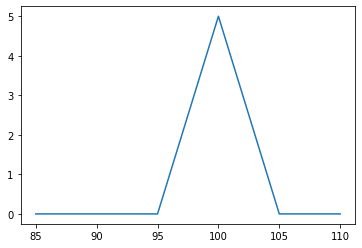

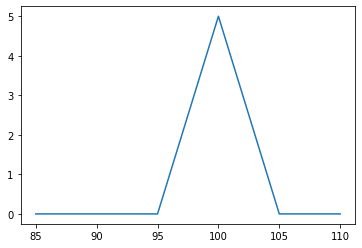

In [ ]:
St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 5
t=0
call=False
K_low=K_mid-K_diff
K_high=K_mid+K_diff

bf_spread=ButterflySpread(r,sigma,t,T,K_mid,K_diff,prices,call=call)
bf_spread_NEW=ButterflySpread_NEW(r,sigma,t,T,K_low,K_high,prices,call=call)

plt.plot(*zip(*bf_spread.payoff_range.items()))
plt.show()

plt.plot(*zip(*bf_spread_NEW.payoff_range.items()))
plt.show()

https://math.stackexchange.com/questions/2482197/solving-the-equation-with-sum-of-max-functions-relu

$max(S_T-K_1,0) - 2max(S_T-K_2,0) + max(S_T-K_3,0)$

$\frac{S_T-K_1+|S_T-K_1|}{2} -2 \frac{S_T-K_2+|S_T-K_2|}{2} + \frac{S_T-K_3+|S_T-K_3|}{2}$

$\frac{S_T-K_1+|S_T-K_1| -2(S_T-K_2+|S_T-K_2|) + S_T-K_3+|S_T-K_3|}{2}$

$\frac{-K_1+|S_T-K_1| -2(-K_2 + |S_T-K_2|) -K_3+|S_T-K_3|}{2}$

$\frac{-(K_2-\delta)+|S_T-(K_2-\delta)| -2(-K_2 + |S_T-K_2|) -(K_2+\delta)+|S_T-(K_2+\delta)|}{2}$

$\frac{-K_2+|S_T-(K_2-\delta)| -2(-K_2 + |S_T-K_2|) -K_2+|S_T-(K_2+\delta)|}{2}$

$\frac{|S_T-(K_2-\delta)| -2(|S_T-K_2|) +|S_T-(K_2+\delta)|}{2}$

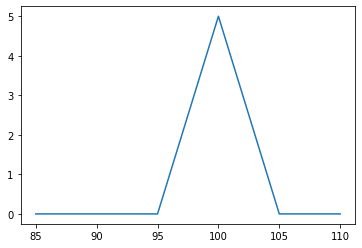

In [ ]:
#max(S1,0) -2max(S2,0) + max(S3,0)

def derived_butterfly(ST,K_low,K_mid,K_high):
  def helper(x):
    return (x+abs(x))/2
  def helper2(x):
    return x+abs(x)

  #return helper(ST-K_low)-2*helper(ST-K_mid)+helper(ST-K_high)
  #return ( helper2(ST-K_low)-2*helper2(ST-K_mid)+helper2(ST-K_high) ) / 2
  #return ( -K_low+abs(ST-K_low) +2*K_mid -2*abs(ST-K_mid) -K_high + abs(ST-K_high) ) / 2
  delt=5
  #return ( -(K_mid-delt)+abs(ST-(K_mid-delt)) +2*K_mid -2*abs(ST-K_mid) -(K_mid+delt) + abs(ST-(K_mid+delt)) ) / 2
  return ( abs(ST-(K_mid-delt)) -2*abs(ST-K_mid) + abs(ST-(K_mid+delt)) ) / 2



temp=derived_butterfly(prices,K_mid-K_diff,K_mid,K_mid+K_diff)
plt.plot(prices,temp)
plt.show()

### Proving out the integral using butterlfies

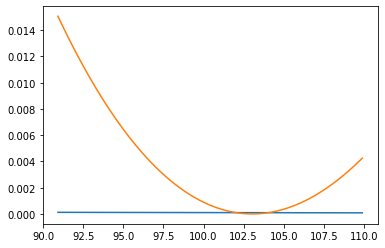

In [ ]:
def spread_payoff(S,K,delta):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_payoff(S,K):
    return np.maximum(S-K,0)
  payoffs=np.array([call_payoff(S,k) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

delta = 0.2
S=100
F=S*np.exp(0.03)
K=100
T=1
ST=np.arange(S/1.05,S*1.05,0.01)

f=(K/F-1)-np.log(K/F)
f*=2/T
my_spread=spread_payoff(ST,K,delta)
my_spread*=(f/(delta/2))

strikes=np.arange(S/1.1,S*1.1,0.1)
#for k in strikes:
#  f=(k/F-1)-np.log(k/F)
#  f*=2/T
#  print(f,1/k**2)
#  print('----------------------------------------------')

plt.plot(strikes,1/(strikes**2))
plt.plot(strikes,((strikes/F-1)-np.log(strikes/F))*(2/T))
plt.show()

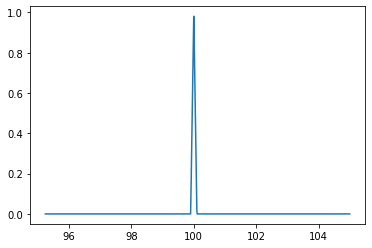

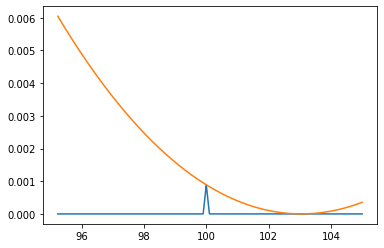

0.1
0.0008910670970163626
0.0008740943904281996
0.0001
9.417645335842484e-05


In [ ]:
def spread_payoff(S,K,delta):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_payoff(S,K):
    return np.maximum(S-K,0)
  payoffs=np.array([call_payoff(S,k) for k in strikes])
  #print(payoffs.shape)
  payoffs=payoffs.T@weights
  return payoffs

delta = 0.2
S=100
F=S*np.exp(0.03)
K=100
T=1

ST=np.arange(S/1.05,S*1.05,0.01)
payoffs=(ST/F-1)-np.log(ST/F)
payoffs*=2/T

my_spread=spread_payoff(ST,K,delta)
my_spread*=(1/(delta/2))

call=True
sigma=0.3
t=T
#bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
#                              K_low=K-delta/2,K_high=K+delta/2,price_range=ST,call=call)
#y=list(bf_payoff.payoff_range.values())
#y=[i/delta for i in y]
#plt.plot(ST,y)
plt.plot(ST,my_spread)
plt.show()


f=(K/F-1)-np.log(K/F)
f*=2/T
my_spread=spread_payoff(ST,K,delta)
my_spread*=(f/(delta/2))
plt.plot(ST,my_spread)
plt.plot(ST,payoffs)
plt.show()

print(delta/2)
print(f)
print( max(my_spread) )

print(1/K**2)
print(1/F**2)


In [ ]:
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=0.1
call=True
S_diff=0.1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )
payoffs*=2/T

strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
def area_approx_check(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx
  area=K_diff*(K_diff/2)/2*scale_factor
  return area
temp=area_approx_check(strike_range,S_ref,K_diff)

def area_approx_check2(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  #spread_approx=K_diff/2
  delta=K_diff/2
  scale_factor=true_payoff/delta
  area=K_diff**2/4*scale_factor
  return area
temp2=area_approx_check2(strike_range,S_ref,K_diff)

def area_approx_check3(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  #spread_approx=K_diff/2
  delta=K_diff/2
  scale_factor=true_payoff/delta
  area=delta*(2*delta)*(1/2) * scale_factor
  return area
temp3=area_approx_check3(strike_range,S_ref,K_diff)

def area_approx_check4(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  #spread_approx=K_diff/2
  delta=K_diff/2
  scale_factor=true_payoff/delta
  area=delta**2 * (true_payoff/delta)
  return area
temp4=area_approx_check4(strike_range,S_ref,K_diff)

def area_approx_check5(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  area=true_payoff*K_diff
  return area
temp5=area_approx_check5(strike_range,S_ref,K_diff)
#  y=[i*scale_factor for i in y]

#plt.scatter(ST,payoffs)
#plt.show()

print( sum([p*S_diff for p in payoffs])  )
print('--------')
print( sum([a for a in temp]) * 2  )
print( sum([a for a in temp2]) * 2  )
print( sum([a for a in temp3]) * 2  )
print( sum([a for a in temp3]) * 2  )
print( sum([a for a in temp4]) * 2  )
print( sum([a for a in temp5])  )

1.1909744083002107
--------
1.1909744083002116
1.1909744083002116
1.1909744083002116
1.1909744083002116
1.1909744083002116
1.1909744083002107


In [ ]:
S,S_ref,T= symbols('S S* T', real=True)
payoff=((S/S_ref)-1)-sp.log(S/S_ref)
#payoff*=2/T
display(integrate(payoff, S))
print('-----------------------')
display(integrate(payoff, S_ref))
print('-----------------------')
display(diff(payoff, S))
print('-----------------------')
first_deriv=diff(payoff, S_ref)
sec_deriv=diff(first_deriv, S_ref)
sec_deriv

S**2/(2*S*) - S*log(S/S*)

-----------------------


S*log(S*) - S**log(S/S*) - 2*S*

-----------------------


1/S* - 1/S

-----------------------


2*S/S***3 - 1/S***2

In [ ]:
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=0.1
call=True
S_diff=0.1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )
payoffs*=2/T

def temp1(K_mid,S_ref,K_diff):
    true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
    true_payoff*=2/T
    return true_payoff

def temp2(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  delta=K_diff/2
  scale_factor=true_payoff/delta
  return (delta**2) * scale_factor
temp2=temp2(ST,S_ref,K_diff)

def temp3(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  delta=K_diff/2
  scale_factor=true_payoff/delta
  #area=delta*(2*delta)*(1/2) * scale_factor
  area=(delta/2)*scale_factor*K_diff
  return area
temp3=temp3(ST,S_ref,K_diff)

print( sum([p*S_diff for p in payoffs])  )
print('--------------------')
print( sum([a for a in temp2]) * 2  )
print( sum([a for a in temp3]) * 2  )



#print( sum([a for a in temp]) * 2  )

def payoff_int(S,F,T):
  return S**2/(F*T)-(2*S*np.log(S/F))/T

S=100
T=1
U=S*1.3
L=S/1.3
payoff_int(S=U,F=S_ref,T=T)-payoff_int(S=L,F=S_ref,T=T)

#INTERGRATE WRT ST here, ST means K here, bot F

1.1909744083002107
--------------------
1.1909744083002116
1.1909744083002107


1.1886561617605764

$\frac{2}{T}[-S_* log(\frac{S_T}{S_*}) + log(S_*)-2 S_*]$

$\frac{2}{T}[ log(S_*)-2 S_* -S_* log(\frac{S_T}{S_*}) ]$

In [ ]:
S,K=symbols('S_T K',real=True)
C=sp.Max(S-K,0)
C/=K**2
int_C=integrate(C,K)
display(int_C)

Piecewise((-log(K) - S_T/K, K <= S_T), (-log(S_T) - 1, True))

In [ ]:
S,S_ref,T= symbols('S S* T', real=True)
payoff=((S/S_ref)-1) -sp.log(S/S_ref)
payoff*=2/T
display(integrate(payoff, S_ref))
#F_T = integrate(payoff, S)

-2*S**log(S/S*)/T + (2*S*log(S*) - 4*S*)/T

$\frac{d}{dF} \frac{S-F}{F}-log(\frac{S}{F})=$
$\frac{F-S}{F^2}$

buterflies give probability, sum the probabilties to get the curve
this integral gives the price of the VIX

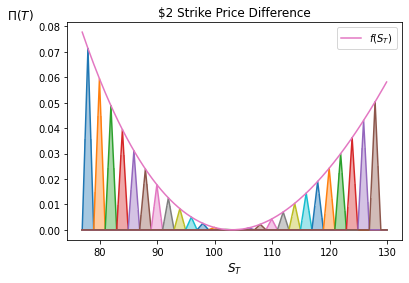

In [ ]:
#from matplotlib.scale import scale_factory
#plt.figure(figsize=(15,10))
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=2
call=True
S_diff=0.25

# Desired Payoff: f(ST) = ((ST/S0)-1)-log(ST/S0)
N_contracts=1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*N_contracts
payoffs*=2*T

#for s,p in zip( range(len(strike_range[:])-1) , payoffs[:] ):
area_approx=0
factors=[]
for s in range(len(strike_range[:])-1):
  bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
                                K_low=strike_range[s],K_high=strike_range[s+1],price_range=ST,call=call)
  y=list(bf_payoff.payoff_range.values())
  mid_price=bf_payoff.K_mid
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  true_payoff*=2*T
  #spread_approx=max(y)
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx

  factors.append(scale_factor)
  area_approx+=K_diff*(K_diff/2)*scale_factor/2

  y=[i*scale_factor for i in y]
  plt.fill_between(ST, y, step="mid", alpha=0.4)
  plt.plot(ST,y)

plt.plot(ST,payoffs,label=r'$f(S_T)$')
plt.legend()
plt.ylabel(r'$\Pi(T)$',size=12,rotation='horizontal',loc='top') #,
plt.xlabel('$S_T$',size=12)
plt.title(f'${K_diff} Strike Price Difference')
plt.show()

#print(factors)
# f(S)/g(S)

In [ ]:
#print(payoffs.sum())#true payoff
T=1
def payoff_int(S,S_ref):
  payoff_integral = S**2/(2*S_ref) - S*np.log(S/S_ref)
  payoff_integral*=(2/T)
  return payoff_integral

print(payoff_int(S0*1.3,S_ref)-payoff_int(S0/1.3,S_ref))
print( sum([p*S_diff for p in payoffs])  )
print(area_approx*2)
print(area_approx)

1.1886561617605764
1.2012089835845086
1.1262928991202568
0.5631464495601284


In [ ]:
#from matplotlib.scale import scale_factory
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=1
call=True
S_diff=0.25

# Desired Payoff: f(ST) = ((ST/S0)-1)-log(ST/S0)
N_contracts=1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*N_contracts

area_approx=0
factors=[]
for s in range(len(strike_range[:])-1):
  bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
                                K_low=strike_range[s],K_high=strike_range[s+1],price_range=ST,call=call)
  #y=list(bf_payoff.payoff_range.values())
  mid_price=bf_payoff.K_mid
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx
  #factors.append(scale_factor)
  area_approx+=K_diff*(K_diff/2)*scale_factor/2
  #y=[i*scale_factor for i in y]


def payoff_int(S,S_ref):
  return S**2/(2*S_ref) - S*np.log(S/S_ref)

print(payoff_int(S0*1.3,S_ref)-payoff_int(S0/1.3,S_ref))
print( sum([p*S_diff for p in payoffs])  )
print(area_approx*2) # you only have half the area because of they are triangles
print(area_approx)

0.5943280808802882
0.6006044917922543
0.5918657673977897
0.29593288369889487


$ f(S_T)= \frac{S_T}{S_*}-1 - log(\frac{S_T}{S_0}) $

$ F(S_T) = \int_{S_T=S_L}^{S_T=S_H}f({S_T}) = \frac{S_T^2}{2S_*} + S_T - ( (S_Tlog(S_T) - S_T) - (S_Tlog(S_*) ) $



In [ ]:
S0=100
r=0.03
T=1
t=0
S_ref=S0*np.exp(r*(T-t))
S_diff=0.25
ST = np.arange(S0/1.3,S0*1.3,S_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*(2/T)

S,S_ref,T= symbols('S S* T', real=True)
payoff=((S/S_ref)-1) -sp.log(S/S_ref)
payoff*=2/T
display(integrate(payoff, S))
F_T = integrate(payoff, S)

print('-----------------')
display(integrate(payoff, S_ref))
print('-----------------')

print( float(F_T.subs({S:S0*1.3, S_ref:S0*sp.exp(r*(T-t)), T:1})) - float(F_T.subs({S:S0/1.3, S_ref:S0*sp.exp(r*(T-t)), T:1})) )

S=100
r=0.03
T=1
t=0
S_ref=S0*np.exp(r*(T-t))
def payoff_int(S,S_ref,T):
  return (2/T) * (S**2/(2*S_ref) - S*np.log(S/S_ref))

print(payoff_int(S*1.3,S_ref,T)-payoff_int(S/1.3,S_ref,T))
print( sum([p*S_diff for p in payoffs])  )

#float( bs_delta.subs({S0:100, sig:0.3, K:100, T:1, r:0.03})  )

#print(pd.DataFrame(X).shape)
#print(f'{len(strikes)} different strikes')
#print(f'{len(ST)} different prices')



S**2/(S**T) - 2*S*log(S/S*)/T

-----------------


-2*S**log(S/S*)/T + (2*S*log(S*) - 4*S*)/T

-----------------
1.1886561617605338
1.1886561617605764
1.2012089835845086


In [ ]:
print(f'{len(strikes)} different strikes')
print(f'{len(ST)} different prices')
print(pd.DataFrame(X).shape)

payoff
print( sum([p*S_diff for p in payoffs]) )

#X1=X.copy()
#for s,k in zip(range(len(strikes)),strikes):
#   X1[s][:] /= k**2
#sum(X1)

18 different strikes
54 different prices
(17, 54)
1.2529784535750361


In [ ]:
1.2529784535750361

In [ ]:
pd.DataFrame(X).shape

(53, 107)

In [ ]:
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=0.1
call=True
S_diff=0.25

ST = np.arange(S0/1.3,S0*1.3,S_diff)
#strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
strike_range = np.arange(50,140+1,K_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )
payoffs*=2/T

S=125

rep_payoff=0
#for s in range(len(strike_range[:])-1):
for s in strike_range[:]:
  #bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,K_low=strike_range[s],K_high=strike_range[s+1],price_range=[S],call=call)
  bf_payoff=ButterflySpread(r=r,sigma=sigma,t=t,T=T,K_mid=s,K_diff=K_diff,price_range=[S],call=True)
  y=list(bf_payoff.payoff_range.values())


  #mid_price=bf_payoff.K_mid
  mid_price=s
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  true_payoff*=2/T
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx

  area_approx+=K_diff*(K_diff/2)*scale_factor/2
  y=[i*scale_factor for i in y]
  #print(y)
  rep_payoff+=y[0]

def temp_func(S,F,T=1):
  payoff=((S/F)-1)
  payoff-=-np.log(S/F)
  payoffs=2/T
  return payoff

print(S)
print(rep_payoff)
print(temp_func(S,S_ref))

125
79.41508150010235
0.4062004682498448


### Log Contract Components

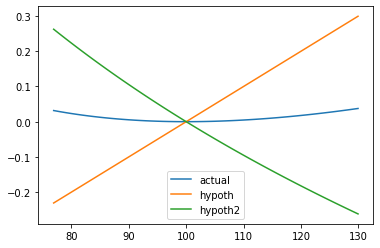

In [ ]:
#Log contract
S0=100
T=1
ST=np.arange(S0/1.3,S0*1.3)
payoffs=( ((ST/S0)-1)-np.log(ST/S0) )
payoffs2= ((ST/S0)-1)
payoffs3=-np.log(ST/S0)
#payoffs*=2/T
plt.plot(ST,payoffs,label='actual')
plt.plot(ST,payoffs2,label='hypoth')
plt.plot(ST,payoffs3,label='hypoth2')
plt.legend()
plt.show()

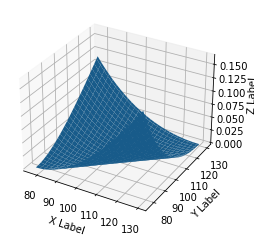

In [ ]:

#fig = plt.figure()
#ax = plt.axes(projection='3d')
S=100
T=1
S0=np.arange(S/1.3,S*1.3)
ST=np.arange(S/1.3,S*1.3)
payoffs=( ((ST/S0)-1)-np.log(ST/S0) )
#ax.plot3D(S0, ST, payoffs)

def fun(x, y):
    payoff=x/y
    payoff-=1
    payoff-=np.log(x/y)
    return payoff


fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
x = y = np.arange(S/1.3,S*1.3)
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
import random
S_sub=random.randint(1,200)
K_sub=random.randint(1,200)
T_sub=random.uniform(0,1)
sig_sub=random.uniform(0.1,0.9)

S_sub=100
K_sub=91
T_sub=0.9
sig_sub=0.3

S0, K, r, sig, T, var = symbols('S_T K r \sigma T \sigma^2', real=True)
d1 = (sp.log(S0/K) + (r + sig**2/2) * T)/(sig*sp.sqrt(T))
d2 = d1 - sig*sp.sqrt(T)
x = Normal('x', 0, 1)
c = S0 * simplify(cdf(x))(d1) - K * sp.exp(-r*T) * simplify(cdf(x))(d2)
print( float(c.subs({S0:S_sub, sig:sig_sub, K:K_sub, T:T_sub, r:0.03})) )

d1 = (sp.log(S0/K) + (r + var/2) * T)/(sp.sqrt(T*var))
d2 = d1 - sp.sqrt(T*var)
x = Normal('x', 0, 1)
c = S0 * simplify(cdf(x))(d1) - K * sp.exp(-r*T) * simplify(cdf(x))(d2)
p = K * sp.exp(-r*T)*simplify(cdf(x))(-d2) - S0*simplify(cdf(x))(-d1)
print( float(c.subs({S0:S_sub, var:sig_sub**2, K:K_sub, T:T_sub, r:0.03})) )
print('---------------------')
var_exp=diff(c,var)
var_exp

print( float(var_exp.subs({S0:S_sub, var:sig_sub**2, K:K_sub, T:T_sub, r:0.03})) )
print( float(var_exp.subs({S0:S_sub, var:sig_sub**2, K:K_sub, T:T_sub, r:0.03})) * T_sub)

def vega_exposure(S,K,sigma,tau):
    v=sigma**2
    def bs_d1(S,K,v):
      d1=np.log(S/K)
      d1+=(0.03+v/2)*tau
      d1/=np.sqrt(v*tau)
      return d1
    d1=bs_d1(S,K,v)
    print(f'd1:{d1}')
    vega=np.exp(-d1**2/2)
    vega/=(math.pi*2)**(1/2)
    vega*=S/(2*v**(1/2))
    vega*=tau
    return vega

def vega_exposure_2(S,K,sigma,tau):
    v=sigma**(1/2)
    def bs_d1(S,K,sigma,tau):
      """3% rf rate"""
      return (np.log(S/K) + (0.03 + sigma**2/2) * tau)/(sigma*np.sqrt(tau))
    d1=bs_d1(S,K,sigma,tau)
    print(f'd1:{d1}')
    vega=np.exp(-d1**2/2)
    vega/=np.sqrt(math.pi*2)
    vega*=(S*np.sqrt(tau))/(2*sigma)
    vega*=tau
    return vega
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print( vega_exposure(S_sub,K_sub,sig_sub,T_sub) )
print( vega_exposure_2(S_sub,K_sub,sig_sub,T_sub) )

print('================================')
print(f'call vega: {float(diff(c,var).subs({S0:S_sub, var:sig_sub**2, K:K_sub, T:T_sub, r:0.03}))}')
print(f'put vega: {float(diff(p,var).subs({S0:S_sub, var:sig_sub**2, K:K_sub, T:T_sub, r:0.03}))}')

17.328528762761366
17.328528762761366
---------------------
53.66470047478973
48.29823042731076
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
d1:0.5685447742984143
50.91080503531652
d1:0.5685447742984144
48.29823042731077
call vega: 53.66470047478973
put vega: 53.66470047478973


$\frac{\partial C_{BS}}{\partial \sigma^2}=\frac{S \sqrt{\tau}}{2 \sigma} \frac{exp(-d_1^2/2)}{\sqrt{2 \pi}}$

In [ ]:
#reconcile the variance xpsoures

<ipython-input-4-93bde387f5eb>:37: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13
<ipython-input-4-93bde387f5eb>:16: RuntimeWarning: divide by zero encountered in true_divide
  d1/=np.sqrt(v*tau)


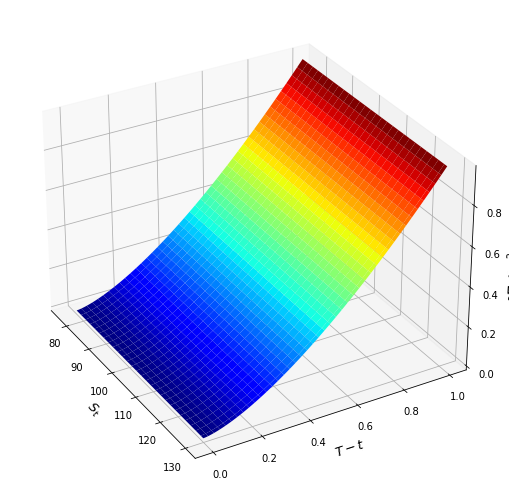

In [ ]:
from matplotlib import cm
S=100
K=100
S_diff=1
sigma=0.3
T=1
St=np.arange(S/1.3,S*1.3,S_diff)
tau=T-np.linspace(0,T,252)
strikes=np.arange(1,S*5,1)

def vega_exposure(S,K,sigma,tau):
    v=sigma**2
    def bs_d1(S,K,v):
      d1=np.log(S/K)
      d1+=(0.03+v/2)*tau
      d1/=np.sqrt(v*tau)
      return d1
    d1=bs_d1(S,K,v)
    vega=np.exp(-d1**2/2)
    vega/=(math.pi*2)**(1/2)
    vega*=S/(2*v**(1/2))
    vega*=tau
    return vega

def portfolio_vega(S,strikes,sigma,tau,T):
  tot_vega=0
  for k in strikes:
    indv_vega=vega_exposure(S,k,sigma,tau)
    indv_vega/=k**2
    tot_vega+=indv_vega
  #tot_vega=sum([vega_exposure(S,k,sigma,tau)/k^2 for k in strikes])
  tot_vega*=2/T
  return tot_vega

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.dist = 13
prices, timeline = np.meshgrid(St, tau)
#vega = np.array(vega_exposure(np.ravel(prices),K,sigma,np.ravel(timeline)))
#vega /= K**2
vega=np.array(portfolio_vega(np.ravel(prices),strikes,sigma,np.ravel(timeline),T))
vega = vega.reshape(prices.shape)

surf = ax.plot_surface(prices, timeline, vega,cmap=cm.jet)
ax.set_xlabel('$ S_t $',fontsize=13)
ax.set_ylabel('$ T-t $',fontsize=13)
ax.set_zlabel(r'$ \partial \Pi_t / \partial \sigma^2 $',fontsize=14)

#ax.zaxis.label.set_rotation(180)

fig.set_size_inches(10, 7)
#fig.set_size_inches(15, 15) #used n paper

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
#fig.set_tight_layout(True)

ax.view_init(None,-30)
plt.show()


In [ ]:
help(ax.ylabel)

AttributeError: ignored

### Using Calls and Puts (proving the wieghts are 1/K^2)

In [ ]:
St, F, T = symbols('S_t F T', real=True)
fwd_contracts = (St-F)/F
#fwd_contracts = (St/F)-1
log_contract = sp.log(St/F)
final = fwd_contracts-log_contract
#final*=2/T
display(final)
print('--------------------------')

dV_dF = diff(final,F)
display(dV_dF)
print('--------------------------')
display(integrate(final,F))
#buying 1/K^2 calls gives you the derivative of the payoff

-log(S_t/F) + (-F + S_t)/F

--------------------------


-(-F + S_t)/F**2

--------------------------


-F*log(S_t/F) - 2*F + S_t*log(F)

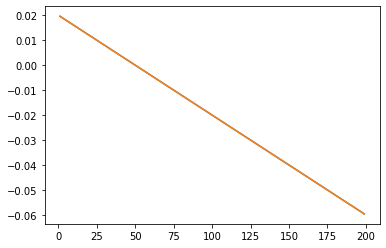

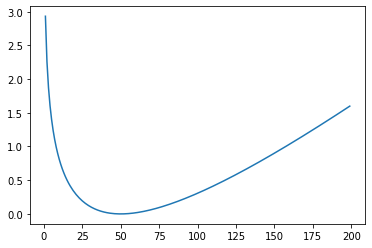

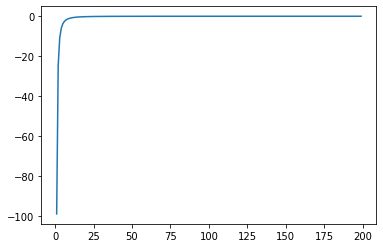

In [ ]:
F=10
S=np.arange(1,20,1)
#for s in S:
  #print(s,(F-s)/F**2)
  #print('---------')

F=50
S=np.arange(1,200,1)
plt.plot(S,(F-S)/F**2)
plt.plot(S,1/F-S/F**2)
plt.show()

plt.plot(S,(S-F)/F-np.log(S/F))
plt.show()


F=np.arange(1,200,1)
S=100
#plt.plot(F,(S-F)/F-np.log(S/F))
plt.plot(F,(F-S)/F**2)
plt.show()


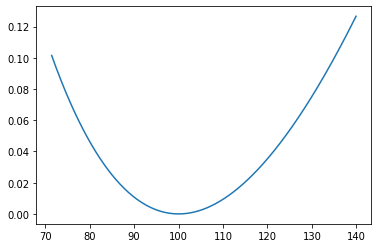

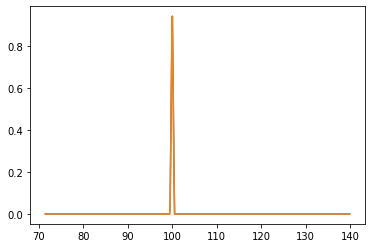

In [ ]:
S=100
T=1
ST=np.arange(S/1.4,S*1.4,0.1)
S_ref=100
payoff=(ST/S_ref)-1
payoff-= np.log(ST/S_ref)
payoff *= 2/T

plt.plot(ST,payoff)
plt.show()

delta=0.5
K=100
call_butt = abs(ST-K-delta)-2*abs(ST-K)+abs(ST-K+delta)
put_butt = abs(K-delta-ST)-2*abs(K-ST)+abs(K+delta-ST)
plt.plot(ST,call_butt)
plt.plot(ST,put_butt)
plt.show()

In [ ]:
print(strikes[0],strikes[-1])
print('---------------')
for i in range(len(strikes)-1):
  print(strikes[i],strikes[i+1])


-6.096897407090037 0.169 -1.0161495678483394
0.939967831583473 0.15655091471124694 0.15666130526391214
0.8731418463045664 0.14542838555560528 0.14552364105076104
0.8131982914241038 0.13545042073786018 0.135533048570684
0.7592233532225379 0.12646520036876954 0.12653722553708965
0.7104500223774715 0.11834526706465223 0.1184083370629119
0.666230671765772 0.11098298085839098 0.11103844529429534
0.6260154302970554 0.10428693346431936 0.10433590504950924
0.589334993642213 0.09817909726353362 0.09822249894036882
0.5557868610839451 0.09259254186251269 0.09263114351399085
0.5250242396057474 0.08746959267118679 0.08750403993429123
0.4967470403576628 0.08276033634975988 0.0827911733929438
0.4706945283725894 0.07842140041131793 0.07844908806209823
0.4466392874418652 0.07441495097639902 0.07443988124031087
0.42438223790539076 0.07070786522495143 0.07073037298423179
0.40374850251427086 0.06727104459194538 0.0672914170857118
0.3845839592919176 0.06407884200053386 0.06409732654865292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


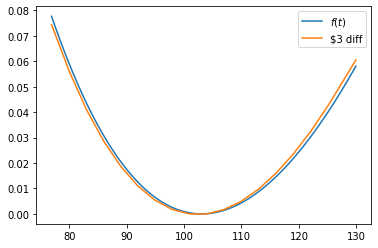

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
#t=0
t=1
T=1
S_ref=S0*np.exp(r*T)
S_diff=0.1
K_diff=3

ST = np.arange(S0/1.3,(S0*1.3),S_diff)
payoffs = ((ST/S_ref)-1)-np.log(ST/S_ref)
payoffs*=(2/T)
strikes = np.arange(S0/1.3,S0*1.3,K_diff )

def p_func(S,F,t):
  payoff =((S/F)-1)-np.log(S/F)
  payoff *=(2/T)
  return payoff

rep_payoff=np.zeros(len(ST))
cum_weight=0
for i in range(len(strikes)-1):
  k_0=strikes[i]
  k_1=strikes[i+1]
  f_0=p_func(k_0,S_ref,T)
  f_1=p_func(k_1,S_ref,T)
  slope=(f_1-f_0)/(k_1-k_0)

  #weight=1/(k_0**2)
  weight=slope-cum_weight
  #weight/=2

  cum_weight+=weight
  #print(weight,1/(k_0**2),weight/2)

  print(weight*1_000,1/(k_0**2)*1_000,(weight/2/K_diff)*1_000)
  #print(round(weight,5),round(1/(k_0**2),5),round(weight*2,5))

  if k_0<=S_ref:
    call=False
  else:
    call=True

  opt_payoff=BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=k_0,call=call).payoff
  opt_payoff*=weight
  rep_payoff+=opt_payoff

#print(len(strikes))

plt.plot(ST,payoffs,label='$f(t)$')
plt.plot(ST,rep_payoff,label=f'${K_diff} diff')
plt.legend()
plt.show()

#half of K_dist is 1/k**2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


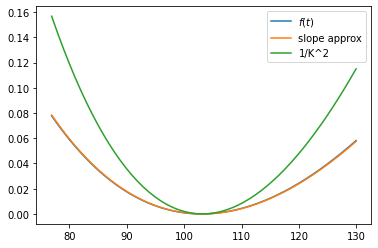

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
#t=0
t=1
T=1
S_ref=S0*np.exp(r*T)
S_diff=0.1
K_diff=0.5

ST = np.arange(S0/1.3,(S0*1.3),S_diff)
payoffs = ((ST/S_ref)-1)-np.log(ST/S_ref)
payoffs*=(2/T)
strikes = np.arange(S0/1.3,S0*1.3,K_diff )

def p_func(S,F,t):
  payoff =((S/F)-1)-np.log(S/F)
  payoff *=(2/T)
  return payoff

rep_payoff=np.zeros(len(ST))
eqw_payoff=np.zeros(len(ST))
cum_weight=0
for i in range(len(strikes)-1):
  k_0=strikes[i]
  k_1=strikes[i+1]
  f_0=p_func(k_0,S_ref,T)
  f_1=p_func(k_1,S_ref,T)
  slope=(f_1-f_0)/(k_1-k_0)

  #weight=1/(k_0**2)
  weight=slope-cum_weight
  #weight/=2
  weight_2=1/(k_0**2)

  cum_weight+=weight
  #print(weight,1/(k_0**2),weight/2)


  if k_0<=S_ref:
    call=False
  else:
    call=True

  opt_payoff=BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=k_0,call=call).payoff
  opt_payoff*=weight

  eqw_payoff+=weight_2*BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=k_0,call=call).payoff
  rep_payoff+=opt_payoff

#payoffs*=100
#rep_payoff*=100
#eqw_payoff*=100

#eqw_payoff*=-1
#eqw_payoff += (ST-S_ref)/S_ref
eqw_payoff*=2/T

plt.plot(ST,payoffs,label='$f(t)$')
plt.plot(ST,rep_payoff,label=f'slope approx')
plt.plot(ST,eqw_payoff,label=f'1/K^2')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def spread_payoff(S,K,delta):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_payoff(S,K):
    return np.maximum(S-K,0)
  payoffs=np.array([call_payoff(S,k) for k in strikes])
  #print(payoffs.shape)
  payoffs=payoffs.T@weights
  return payoffs

delta = 0.1
S=100
F=S*np.exp(0.03)
K=100

ST=np.arange(S/1.2,S*1.2,0.1)
#spread_payoff(S,K,delta)

#plt.plot(ST,spread_payoff(ST,K,delta))
#plt.show()



f=(S/F-1)-np.log(S/F)

strikes are rows, STs the columns

$
\begin{equation*}
\textbf{X}^{NxM}=
\begin{array}{rcl}
\\ \begin{array}{r}  (S_T)_1\ & (S_T)_2\ & \cdots\ (S_T)_M\  \end{array} \\
\begin{array}{c}  K_1\\   K_2\\  \vdots\\  K_N\\ \end{array}
\begin{pmatrix}
payoff() & \textbf{w}_{1,2} & \cdots & \textbf{w}_{1,I} \\
\textbf{w}_{2,1} & \textbf{w}_{2,2} & \cdots & \textbf{w}_{2,I} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\textbf{w}_{N,1} & \textbf{w}_{N,2} & \cdots & \textbf{w}_{N,I}
\end{pmatrix}
\end{array}
\end{equation*}
$

$
\begin{equation*}
\textbf{S}^{Mx1}
\
\begin{pmatrix} \end{pmatrix}
\end{equation*}
$

In [ ]:
for s in range(len(strike_range[:])-1):
  bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
                                K_low=strike_range[s],K_high=strike_range[s+1],price_range=ST,call=call)
  #y=list(bf_payoff.payoff_range.values())
  mid_price=bf_payoff.K_mid
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx
  area_approx+=K_diff*(K_diff/2)*scale_factor/2

(107,)
(107,)
107 different strikes
266 different prices
(107, 266)
---------


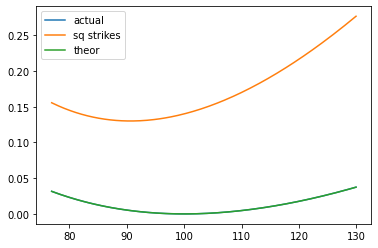

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
t=0
T=1
S_ref=S0*np.exp(r*T)
S_diff=0.2
K_diff=0.5

# Desired Payoff f(ST) = ((ST/S0)-1)-log(ST/S0)
ST = np.arange(S0/1.3,(S0*1.3),S_diff)
payoffs = ((ST/S0)-1)-(np.log(ST/S_ref)+np.log(S_ref/S0))
#payoffs = ((ST/S_ref)-1)-np.log(ST/S_ref)
#payoffs = np.log(ST/S_ref)
strikes = np.arange( (S0/1.3),(S0*1.3),K_diff )

X=[]
for strike in strikes[:]:
  if strike<=S_ref:
    call=True
  else:
    call=False
  bso = BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=strike,call=call)
  X.append(bso.payoff)

print(np.array([1/k**2 for k in strikes]).shape)
print((np.linalg.pinv(X).T@payoffs).shape)
print(f'{len(strikes)} different strikes')
print(f'{len(ST)} different prices')
print(pd.DataFrame(X).shape)
print('---------')
weights=np.linalg.pinv(X).T@payoffs
theor_weights=np.array([1/k**2 for k in strikes])

#print(pd.DataFrame(X).shape)
#print(pd.DataFrame(weights).shape)
#print(pd.DataFrame(theor_weights).shape)


plt.plot(ST,np.array(X).T@weights,label='actual')
plt.plot(ST,np.array(X).T@theor_weights,label='sq strikes')
plt.plot(ST,payoffs,label='theor')
plt.legend()
plt.show()

In [ ]:
print(weights*100)
print('=================')
print(theor_weights*100)

[-0.68994364  0.00834139  0.00823468  0.00813001  0.00802732  0.00792657
  0.0078277   0.00773067  0.00763543  0.00754194  0.00745016  0.00736004
  0.00727155  0.00718465  0.00709929  0.00701545  0.00693308  0.00685215
  0.00677264  0.0066945   0.0066177   0.00654222  0.00646802  0.00639508
  0.00632336  0.00625284  0.0061835   0.0061153   0.00604823  0.00598225
  0.00591735  0.0058535   0.00579067  0.00572886  0.00566802  0.00560815
  0.00554923  0.00549122  0.00543413  0.00537791  0.00532257  0.00526808
  0.00521441  0.00516157  0.00510952  0.00505826  0.00500776  0.00495802
  0.00490902  0.00486073  0.00481316  0.00476628  0.00472008  0.00467455
  0.00462968  0.00458545  0.00454185  0.00449887  0.0044565   0.00441472
  0.00437353  0.00433291  0.00429285  0.00425335  0.00421439  0.00417596
  0.00413806  0.00410067  0.00406378  0.00402739  0.00399149  0.00395606
  0.00392111  0.00388661  0.00385257  0.00381898  0.00378582  0.00375309
  0.00372078  0.00368889  0.00365741  0.00362633  0

$\frac{S_T-S_0}{S_0}-log(\frac{S_T}{S_0})$
$=\frac{S_T-S_0}{S_0}-log(\frac{S_T}{F})-log(\frac{F}{S_0})$

$\frac{\partial^2}{\partial^2F} log(\frac{S_T}{F})=\frac{1}{F^2}$


$log(\frac{S_T}{F})=log(1)$

$-\frac{1}{k}[max(0,0)-max(0,0)]$

$+ \int_0^F\frac{1}{K^2}(K-S_T)^+dK$

$+ \int_F^\infty\frac{1}{K^2}(S_T-K)^+dK $

=$0+0+ \int_0^F\frac{1}{K^2}(K-S_T)^+dK + \int_F^\infty\frac{1}{K^2}(S_T-K)^+dK$

In [ ]:
St, F, T = symbols('S_t F T', real=True)
log_contract = sp.log(St/F)
first_deriv = diff(log_contract,F)
call=sp.Max(St-F,0)
put=sp.Max(F-St,0)

display(first_deriv*(call-put))
final=first_deriv*(call-put)
int(final.subs({St:100,F:100}))

-(Max(0, -F + S_t) - Max(0, F - S_t))/F

0

### Butterflies and probailites

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def spread_payoff(S,K,delta):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_payoff(S,K):
    return np.maximum(S-K,0)
  payoffs=np.array([call_payoff(S,k) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

delta = 0.1
S=100
K=100
T=1
t=0
F=S*np.exp(0.03*(T-t))

ST=np.arange(0,S*3,delta*2)

#payoffs=(ST/F-1)-np.log(ST/F)
#payoffs*=2/T
my_spread=spread_payoff(ST,K,delta)
#my_spread*=(1/(delta/2))


#plt.plot(ST,my_spread)
#plt.show()


tot_payoff=0
for k in range(0,S*2):
  px=spread_payoff(ST,k,delta).sum()
  px*=delta
  tot_payoff+=px
  #plt.scatter(k,tot_payoff)
  #plt.scatter(ST,spread_payoff(ST,k,delta))
tot_payoff



NameError: ignored

In [ ]:
def spread_payoff(S,K,delta):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_payoff(S,K):
    return np.maximum(S-K,0)
  payoffs=np.array([call_payoff(S,k) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

def replic_func(S,F,T):
  g=S/F-1
  g-=np.log(S/F)
  g*=2/T
  return g

delta = 0.1 #width
S=100
K=100
T=1
t=0
F=S*np.exp(0.03*(T-t))
#ST=np.arange(0,S*3,delta*2)
ST=np.arange(0,S*3,1)

tot_payoff=0
for k in range(0,S*3):
  payoff=spread_payoff(ST,k,delta)
  scale_factor= replic_func(k,F,T)/(delta/2) #delta is the width, half the width is the payoff
  payoff*=scale_factor
  plt.plot(ST,payoff)

#plt.plot(ST,replic_func(ST,F,T))
plt.show()



#my_spread=spread_payoff(ST,K,delta)
#my_spread*=(f/(delta/2))

ST=np.arange(0,S*3,1)
tot_payoff=0
#for k in range(0,S*2):
for k in np.arange(0,S*3,delta*2):
  payoff=spread_payoff(ST,k,delta)
  payoff*=(delta/2)
  tot_payoff+=payoff
  #plt.plot(ST,tot_payoff)
  plt.plot(ST,payoff)
print(tot_payoff.sum())
plt.show()



In [ ]:
final_dict={}
ST=np.arange(0,S*3,1)
for s in ST:
  tot_payoff=0
  for k in np.arange(0,S*3,delta*2):
    payoff=spread_payoff(s,k,delta)
    payoff/=(delta/2)
    tot_payoff+=payoff
  #print(tot_payoff.sum())
  final_dict[s]=tot_payoff

final_dict

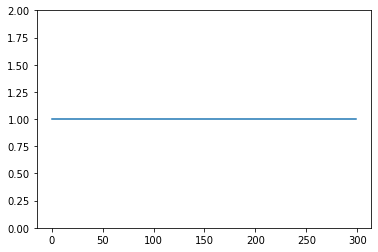

In [ ]:
x, y = zip(*final_dict.items())
plt.ylim(0, 2)
plt.plot(x, y)
#plt.plot(x,[i*100 for i in y])
plt.show()

<ipython-input-192-9d124c5aaed6>:12: RuntimeWarning: divide by zero encountered in log
  g-=np.log(S/F)
<ipython-input-193-f248b816f1c3>:5: RuntimeWarning: invalid value encountered in multiply
  payoff*=scale_factor
<ipython-input-193-f248b816f1c3>:8: RuntimeWarning: invalid value encountered in true_divide
  payoff/=replic_func(k,F,T)/(delta/2)


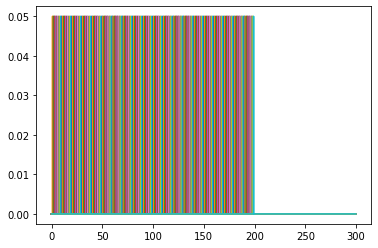

0.995000000000053


In [ ]:
tot_payoff=0
for k in range(0,S*2):
  payoff=spread_payoff(ST,k,delta)
  scale_factor= replic_func(k,F,T)/(delta/2)
  payoff*=scale_factor

  #payoff/=replic_func(k,F,T)
  payoff/=replic_func(k,F,T)/(delta/2)

  if not math.isnan(payoff.max()):
    tot_payoff+=payoff.max()*delta
  plt.plot(ST,payoff)
plt.show()
print(tot_payoff)

In [ ]:
ST=100
K=ST
delta=1
call_butt = max(ST-K-delta,0)-2*max(ST-K,0)+max(ST-K+delta,0)

print(call_butt)
print(delta)

1
1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/personal/VIX/'
from bsopm import BSOPM_Class

Mounted at /content/gdrive
/content/gdrive/My Drive/personal/VIX


/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/personal/VIX/bsopm.py:38: RuntimeWarning: invalid value encountered in true_divide
  gamma /= (St*sig*np.sqrt(t))
/content/gdrive/My Drive/pe

0.9899999999995261


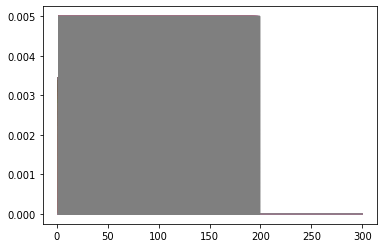

In [ ]:
def butt_spread(S,K,delta,r,sigma,t,T):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_price(S,K,r,sigma,t,T):
    call=True
    price=BSOPM_Class(S0=S,r=r,sigma=sigma,t=t,T=T,K=K,call=call).price
    return price
  payoffs=np.array([call_price(S,k,r,sigma,t,T) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

def replic_func(S,F,T):
  g=S/F-1
  g-=np.log(S/F)
  g*=2/T
  return g

r=0.03
sigma=0.3
T=1
t=T
St=100
F=St*np.exp(r*(T-t))
k=100
call=True
delta = 0.1
ST=np.arange(1,St*3,delta*2)

tot_payoff=0
for k in range(2,St*2):
  #print(k)
  payoff=butt_spread(ST,k,delta,r,sigma,t,T)*np.exp(r*(T-t))
  payoff*=delta
  tot_payoff+=payoff
  plt.plot(ST,tot_payoff)
print(tot_payoff.sum())
plt.show()

#print( replic_func(St*3,F,T-t)*np.exp(r*(T-t))  )
#print( replic_func(St/3,F,T-t)*np.exp(r*(T-t))  )


#plt.plot(ST, butt_spread(ST,2,delta,r,sigma,t,T)*np.exp(r*(T-t)) )
#plt.show()

In [ ]:
r=0.03
sigma=0.3
T=1
t=T
St=100
F=St*np.exp(r*(T-t))
k=100
call=True
delta = 0.1
ST=np.arange(1,St*3,1)

tot_payoff=0
#for k in np.arange(10,St*4,delta*2): #set delta to 2
for k in np.arange(2,St*2,delta*2):
  payoff=butt_spread(ST,k,delta,r,sigma,t,T)*np.exp(r*(T-t))
  payoff*=delta
  #payoff/=delta
  payoff=np.nan_to_num(payoff, nan=0)
  tot_payoff+=payoff
  plt.plot(ST,tot_payoff)
print(tot_payoff.sum())
plt.ylabel('$f(x)$')
plt.xlabel('$S_t$')
plt.show()

Trying this a different way

In [ ]:
def butt_spread(S,K,delta,r,sigma,t,T):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_price(S,K,r,sigma,t,T):
    call=True
    bs_price=BSOPM_Class(S0=S,r=r,sigma=sigma,t=t,T=T,K=K,call=call).price
    return bs_price
  payoffs=np.array([call_price(S,k,r,sigma,t,T) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

def replic_func(S,F,T):
  g=S/F-1
  g-=np.log(S/F)
  g*=2/T
  return g

r=0.03
sigma=0.3
T=1
t=T*0.999999999999999
t=0.25
St=100
F=St*np.exp(r*(T-t))
k=100
call=True
delta = 1
ST=np.arange(1,St*3,delta*2)


final_dict={}
ST=np.arange(1,St*3,1)
for s in ST:
  tot_payoff=0
  for k in np.arange(1,St*3,delta):
    payoff=butt_spread(s,k,delta,r,sigma,t,T)*np.exp(r*(T-t))
    payoff/=(delta/2)
    tot_payoff+=payoff
  #print(tot_payoff.sum())
  final_dict[s]=tot_payoff
  print(s,tot_payoff)

#final_dict

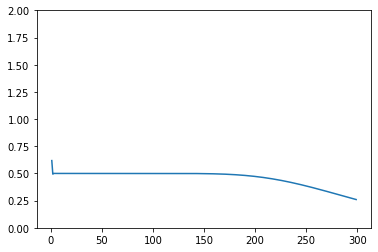

In [ ]:
x, y = zip(*final_dict.items())
plt.ylim(0, 2)
plt.plot(x, y)
#plt.plot(x,[i*100 for i in y])
plt.show()

In [ ]:
T=1
t=T*0.6#.999999999999999
s=100
delta=0.1
tot_payoff=0
for k in np.arange(1,s*4,delta):
  payoff=butt_spread(s,k,delta,r,sigma,t,T)*np.exp(r*(T-t))
  #if round(payoff,5) != 0:
  #  print(round(payoff,5),delta/2,k)

  payoff/= (delta/2)**2
  payoff *= (delta)
  #if round(payoff,5) != 0:
  #print(k,payoff)
  if not pd.isnull(payoff):
    tot_payoff+=payoff
final_dict[s]=tot_payoff


tot_payoff



1.0000000000083427

In [ ]:
r=0.03
sigma=0.3
T=1
t=T*0.999999999999999
#t=0.25
St=100
F=St*np.exp(r*(T-t))
#k=100
call=True
dK = 1
strike_range=np.arange(1,St*3+dK,dK)

final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'sigma':sigma,'delta':dK,'K_low':strike_range[i]-dK/2,'K_mid':strike_range[i],'K_high':strike_range[i]+dK/2,'t':t,'T':T}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-dK/2,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+dK/2,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['B']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['PDF']=final_dict[i]['B']/(final_dict[i]['delta']/2)

df=pd.DataFrame.from_dict(final_dict,orient='index')
df
#df['Prob. f(x)'] = 0.00
#for i in range(1, (len(df.S)-1)):
# df['Prob. f(x)'][i] = df['PDF'][i-1]
#print(df['Prob. f(x)'].sum())
print(df['PDF'].sum())
df

0.9999984867255876


,S,r,sigma,delta,K_low,K_mid,K_high,t,T,C_low,C_mid,C_high,B,PDF
0,100,0.03,0.3,1,0.5,1,1.5,1.0,1,99.5,99.0,98.5,0.0,0.0
1,100,0.03,0.3,1,1.5,2,2.5,1.0,1,98.5,98.0,97.5,0.0,0.0
2,100,0.03,0.3,1,2.5,3,3.5,1.0,1,97.5,97.0,96.5,0.0,0.0
3,100,0.03,0.3,1,3.5,4,4.5,1.0,1,96.5,96.0,95.5,0.0,0.0
4,100,0.03,0.3,1,4.5,5,5.5,1.0,1,95.5,95.0,94.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,100,0.03,0.3,1,295.5,296,296.5,1.0,1,0.0,0.0,0.0,0.0,0.0
296,100,0.03,0.3,1,296.5,297,297.5,1.0,1,0.0,0.0,0.0,0.0,0.0
297,100,0.03,0.3,1,297.5,298,298.5,1.0,1,0.0,0.0,0.0,0.0,0.0
298,100,0.03,0.3,1,298.5,299,299.5,1.0,1,0.0,0.0,0.0,0.0,0.0


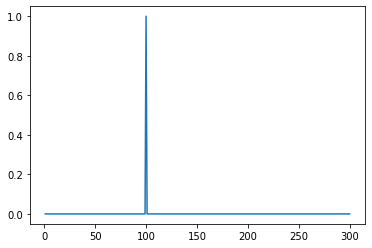

In [ ]:
plt.plot(df.K_mid,df.PDF)

In [ ]:
0.0057+0.044+0.15+0.278+0.281+0.166+0.057+0.011

0.9927000000000001

$\begin{equation}
    \lim_{\delta \to 0} B(K(T),\delta)=
    \begin{cases}
      \delta, & \text{if}\ S=K \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}$

$S-(K-\delta)$

$S-(K+\delta)$


$S-(K-\delta)-(S-K)=\delta$

$S-(K+\delta)-(S-K)=\delta$



$max(S-K+\delta,0)-2max(S-K,0)+max(S-K-\delta,0)$

\\
$S=K$

$\delta+0$

\\
$K-\delta<S<K$


$[max(S-(K-\delta),0)-max(S-K,0)]
+[max(S-(K+\delta),0)-max(S-K,0)]$

\\


$\frac{1}{2} abs(S-K-\delta)-2abs(S-K)+abs(S-K+\delta)$
$\frac{1}{2} abs(S-(K-\delta))-2abs(S-K)+abs(S-(K+\delta))$

$K-\delta<S<K$

$\frac{1}{2} S-(K-\delta)-2(K-S)+S-(K+\delta)$

$\frac{1}{2} S-K+\delta-2K+2S+S-K-\delta$

$\frac{1}{2} 4S-4K+\delta-\delta$

$\frac{1}{2} 4S-4K=2(S-K)$


In [ ]:
delta=2
ST=np.arange(90,110,0.5)
K=100
call_butt=spread_payoff(ST,K,delta)
print(call_butt)


print([abs(2*(s-K)) for s in ST])

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.5 1.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0. ]
[20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


### Scrap Work